<a href="https://colab.research.google.com/github/xpalenik-fnusa/bmi-calculator/blob/main/jupyter/biofeedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
control_sensitivity = 0.2
control_max = 12
control_min = 2

In [24]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab


In [25]:
# !pip install -q --upgrade pandas seaborn matplotlib plotly jupyter-resource-usage

In [26]:
from packaging.version import parse as v
recommendedVersionPandas = v("2.2.2") # google-colab 1.0.0 requires pandas==2.2.2
recommendedVersionSeaborn = v("0.13.2")
recommendedVersionMatplotlib = v("3.10.0")
recommendedVersionPlotly = v("5.24.1")

import pandas as pd
import seaborn as sns
import numpy as np # add version control
import matplotlib
import plotly

print(f"pandas: {pd.__version__} (recommended: {recommendedVersionPandas})")
if v(pd.__version__) < recommendedVersionPandas:
    !pip install -q --upgrade pandas

print(f"seaborn: {sns.__version__} (recommended: {recommendedVersionSeaborn})")
if v(sns.__version__) < recommendedVersionSeaborn:
    !pip install -q --upgrade seaborn

print(f"matplotlib: {matplotlib.__version__} (recommended: {recommendedVersionMatplotlib})")
if v(matplotlib.__version__) < recommendedVersionMatplotlib:
    !pip install -q --upgrade matplotlib

print(f"plotly: {plotly.__version__} (recommended: {recommendedVersionPlotly})")
if v(plotly.__version__) < recommendedVersionPlotly:
    !pip install -q --upgrade plotly

# pip install jupyter-resource-usage

import matplotlib.pyplot as plt
import plotly.express as px

pandas: 2.2.2 (recommended: 2.2.2)
seaborn: 0.13.2 (recommended: 0.13.2)
matplotlib: 3.10.0 (recommended: 3.10.0)
plotly: 5.24.1 (recommended: 5.24.1)


In [27]:
#df = pd.read_csv('output_from_laying_one_hour_then_sitting_half_hour_then_breakfast_45_minutes_using_original_R_implementation.csv')
df = pd.read_csv('correct_breathing_polar_5min_15sec.csv')
df['variability'] = df['HR.difference'] - df['HR.previous.difference']

In [28]:
df = df[['HR', 'Filtered.HR', 'Flame', 'HR.difference', 'variability', 'Flame.control', 'HR.previous.difference']]

In [29]:
#df = df.drop(columns='index')
#df = df.reset_index(drop=True)

In [30]:
df.query("`Flame.control` == True and variability != 0")['variability'].describe()

,variability
count,34.000000
mean,0.287173
std,7.254618
min,-12.659814
25%,-5.972566
50%,1.982655
75%,5.508909
max,13.217712


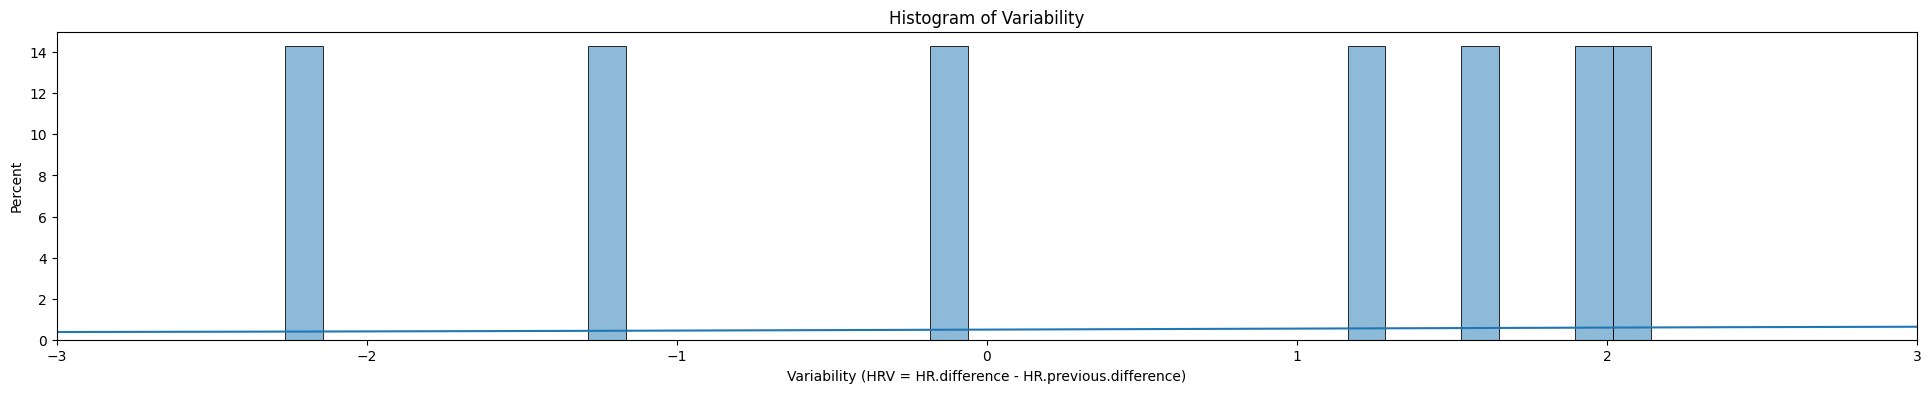

In [31]:
bins = np.linspace(-3, 3)

# Plot histogram
plt.figure(figsize=(24,4))
sns.histplot(df.query("`Flame.control` == True and variability != 0")['variability'], bins=bins, kde=True, stat='percent')

# Label axes
plt.xlabel('Variability (HRV = HR.difference - HR.previous.difference)')
plt.title('Histogram of Variability')
plt.xlim(-3, 3)

# Show plot
plt.show()

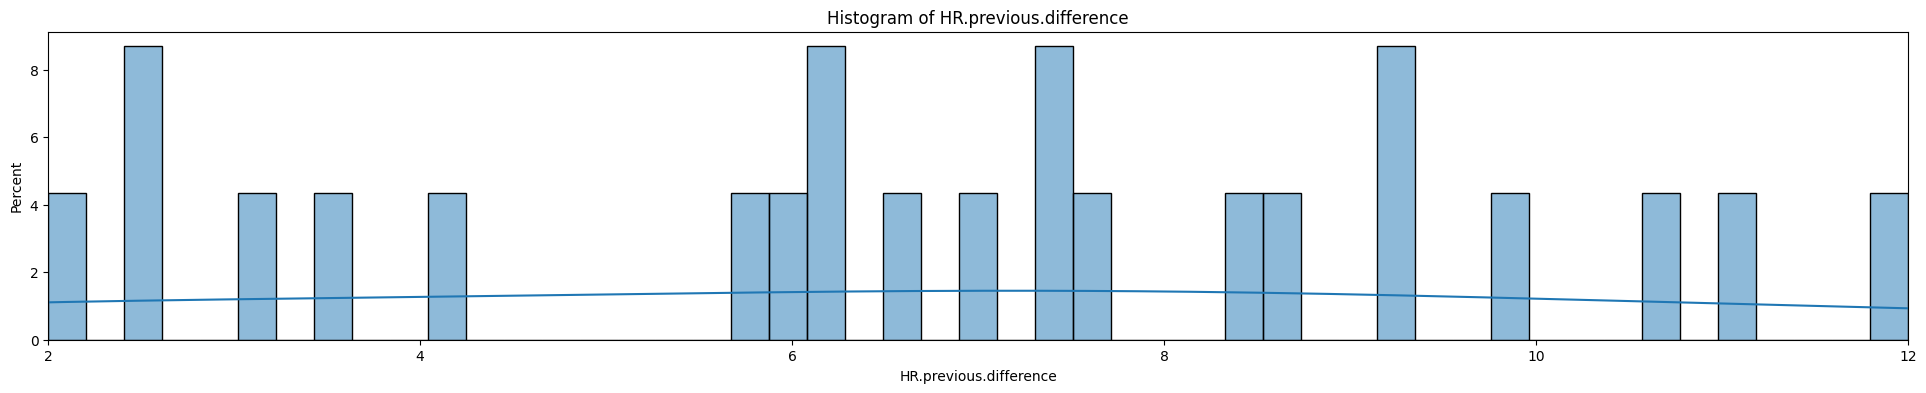

In [32]:
bins = np.linspace(2, 12)

# Plot histogram
plt.figure(figsize=(24,4))
sns.histplot(df.query("`Flame.control` == True")['HR.previous.difference'], bins=bins, kde=True, stat='percent')

# Label axes
plt.xlabel('HR.previous.difference')
plt.title('Histogram of HR.previous.difference')
plt.xlim(2, 12)

# Show plot
plt.show()

In [33]:
# How many percent of flame changes occur incorrectly despite missing trajectory change
df.query("`Flame.control` == True and variability == 0")['variability'].count() / df.query("`Flame.control` == True")['variability'].count()

0.0

In [34]:
lowX = df.index.min()
length = 300
# lowX = int(input(f"Enter start of session (minimum: {df.index.min()}): "))
# length = int(input(f"Enter length of session (maximum: {df.index.max()-lowX}): "))
maxX=lowX+length

lowY = df['Filtered.HR'].clip(lower=df['Filtered.HR'][lowX:maxX].quantile(0.01)).min()
maxY = df['Filtered.HR'].clip(upper=df['Filtered.HR'][lowX:maxX].quantile(0.99)).max()

df = df[lowX:maxX].copy()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(lowY, maxY))
df['scaledIntensity']   = scaler.fit_transform(        df['Flame'].values.reshape(-1, 1))
df['scaledVariability'] = scaler.fit_transform(  df['variability'].values.reshape(-1, 1))
df['scaledDifference']  = scaler.fit_transform(df['HR.difference'].values.reshape(-1, 1))

In [35]:
#       if ((hrv.DIFF >= control.sensitivity) || (cur.DIFF >= control.max)) {flame.action<-"DOWN"; cur.flame<-pre.flame - flame.increment}
#  else if ((hrv.DIFF <= control.sensitivity) || (cur.DIFF <= control.min)) {flame.action<-"UP";   cur.flame<-pre.flame + flame.increment}

conditions = [
    df['Flame.control'] == False,
    (df['variability'] >= control_sensitivity) | (df['HR.difference'] >= control_max), # flame.action<-"DOWN"
    (df['variability'] <= control_sensitivity) | (df['HR.difference'] <= control_min), # flame.action<-"UP"
]

choices = [
    lowY + (maxY - lowY)/2,
    lowY,
    maxY,
]

df['scaledDecision'] = np.select(conditions, choices)

In [36]:
y = ['HR', 'Filtered.HR', 'scaledIntensity', 'scaledVariability', 'scaledDifference']
fig = px.line(df, x=df.index+0.5, y=y, markers=True)

fig.update_layout(
    xaxis=dict(
        title="",
        range=[lowX, maxX],
        rangeslider=dict(visible=True),
        gridcolor='lightgrey',
        dtick=15
    ),
    yaxis=dict(
        title=""
    ),
    height=720,
    showlegend=True
)

fig.show()

In [37]:
s = pd.read_csv('preDIFF_DIFF.csv')

<Axes: xlabel='HR.previous.difference', ylabel='DIFF'>

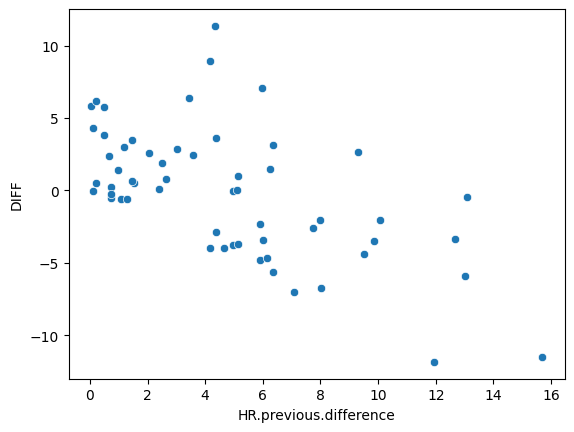

In [38]:
sns.scatterplot(data=s, x='HR.previous.difference', y='DIFF')

Linear function: y = -0.695x + -3.526


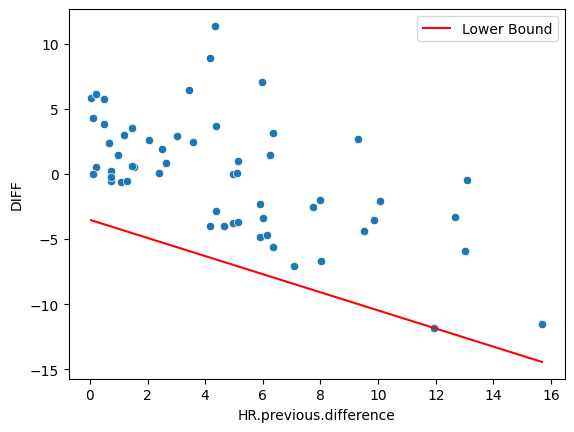

In [39]:
x = s['HR.previous.difference'].values
y = s['DIFF'].values

# Get slope from a simple linear fit
a = np.polyfit(x, y, 1)[0]
# Set intercept so that y = a*x + b is just below all points
b = np.min(y - a * x)

print(f"Linear function: y = {a:.3f}x + {b:.3f}")

# Plot data and the computed line
sns.scatterplot(data=s, x='HR.previous.difference', y='DIFF')
x_range = np.linspace(x.min(), x.max(), 100)
plt.plot(x_range, a * x_range + b, color='red', label='Lower Bound')
plt.legend()
plt.show()